# RQ1 Questions

In [1]:
import json
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import nltk
import re
from array import array
from collections import defaultdict
import collections
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import math
from numpy import linalg as la
import csv
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
with open("data/processed_tweets.json", "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

In [7]:
df_tweets = pd.DataFrame.from_records(data)

This function is to process the query

In [1]:
def processQuery(line):        
    stemming = PorterStemmer()
    stops = set(stopwords.words("english"))
    line=  line.lower()
    line = re.sub('[^a-zA-Z]', ' ', line )                                 ## Transform in lowercase
    line=  line.split()                                 ## Tokenize the text to get a list of terms
    line=[word for word in line if word not in stops]   ##eliminate the stopwords (HINT: use List Comprehension)
    line=[stemming.stem(word) for word in line]         ## perform stemming (HINT: use List Comprehension)
    return line

I used this function to write query results to a tsv file

In [ ]:
def ids2tsv(query,docs,file_name):
    with open(file_name, 'a+', encoding='utf8', newline='') as tsv_file:
        tsv_writer = csv.writer(tsv_file, delimiter='\t')
        tsv_writer.writerow([ query])
        for d_id in docs:
            text = df_tweets['text'][d_id]
            screen_name = df_tweets['user'][d_id]['screen_name']
            date = df_tweets['created_at'][d_id]
            hastags = df_tweets['hashtags'][d_id]
            likes = df_tweets['likes'][d_id]
            retweets = df_tweets['retweets'][d_id]
            followers = df_tweets["user"][d_id]['followers_count']
            user_created = df_tweets["user"][d_id]['created_at']
            tweetid =  df_tweets['id'][d_id]
            url = "https://twitter.com/{}/status/{}".format(screen_name,tweetid)
            tsv_writer.writerow(("", text, screen_name, date,hastags, likes, retweets, url))
        tsv_writer.writerow(["", ""])
    

## TFIDF

In [17]:
def create_index_tfidf(df_tweets):
    numDocuments = len(df_tweets)
    index=defaultdict(list)

    tf=defaultdict(list) 
    df=defaultdict(int)        
    idf=defaultdict(float)


    for i, row in df_tweets.iterrows():
        terms = row['processed_text']

        page_id =  i
        termdictPage={}

        for position, term in enumerate(terms):
            try:
                # if the term is already in the dict append the position to the corrisponding list
                termdictPage[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[page_id, array('I',[position])] 
        
        norm=0
        for term, posting in termdictPage.items(): 
            norm+=len(posting[1])**2
        norm=math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():   
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4))  ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] = df[term] + 1  

        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
            
    for term in df:
        idf[term] = np.round(np.log(float(numDocuments/df[term])),4)
            
    return index, tf, df, idf


In [6]:
def rankDocuments(terms, docs, index, idf, tf):
    docVectors=defaultdict(lambda: [0]*len(terms)) 
    queryVector=[0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) 
    
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): 
        if term not in index:
            continue
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
               
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term] 
    docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    if len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)    
    
    return resultDocs

In [18]:
index, tf, df, idf = create_index_tfidf(df_tweets)

In [7]:
def search_tf_idf(query, index):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=processQuery(query)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs|=set(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf)   
    return ranked_docs

In [13]:
queries=["Biden won elections",
"When lockdown ends",
"Trump has covid",
"Covid is infectious",
"People get infected daily",
"When will the vaccine be ready",
"Covid19 isn’t bad",
"Social distancing affects american people",
"Trump lies about covid",
"Coronavirus cases increase every day",
]

In [46]:
file_nameRQ1b = "TSV/RQ1b.tsv"

In [47]:
with open(file_nameRQ1b, 'a+', encoding='utf8', newline='') as tsv_file:
    tsv_writer = csv.writer(tsv_file, delimiter='\t')
    tsv_writer.writerow(["Query","Tweet", "Username", "Date", "Hashtags","Likes","Retweets","Url"])

In [48]:
for query in queries:
    print(query)
    ranked_docs = search_tf_idf(query, index)
    ids2tsv(query, ranked_docs[:20], file_nameRQ1b)

Biden won elections
When lockdown ends
Trump has covid
Covid is infectious
People get infected daily
When will the vaccine be ready
Covid19 isn’t bad
Social distancing affects american people
Trump lies about covid
Coronavirus cases increase every day


## WORD2VEC

First I tokenize all the words and append it to list of all the words

In [5]:
all_words = []
for terms in df_tweets['processed_text']:
    for word in terms:
        all_words.append(nltk.word_tokenize(word))

In [6]:
word2vec = Word2Vec(all_words, size=50, min_count=1)

In the following cell I compute the vector respresentation for all tweets, which consits in summing all the word2vec vales of the tweet text.
I do this to save computational time when I rank the tweets

In [7]:
tweet2vec = {}
tweetvecList = []
key = 0
for terms in df_tweets['processed_text']:
    tweet2vec[key] = 0
    for word in terms:
        try:
            tweet2vec[key] += (word2vec[word])
        except:
            continue
    if(len(terms) > 0):
        tweet2vec[key] = tweet2vec[key] / len(terms)
        tweet2vec[key] = (tweet2vec[key])
        tweetvecList.append(tweet2vec[key])
    key+=1

I used the same index I compute for tf-idf so I did not compute it again

In [24]:
def rank_word2vec(terms, docs, index, word2vec):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    titleIndex -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """
        
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector=0

    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        
        if term not in index:
            continue
        queryVector+=word2vec[term]
    queryVector = queryVector / len(terms)



    docScores=[ [np.dot(tweet2vec[doc], queryVector), doc] for doc in docs ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    if len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_word2vec(query, index)    
    #print ('\n'.join(resultDocs), '\n')
    return resultDocs

In [9]:
def search_word2vec(query, index):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=processQuery(query)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs|=set(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rank_word2vec(query, docs, index, word2vec)   
    return ranked_docs

In [10]:
file_nameRQ1c = "TSV/RQ1c.tsv"

In [23]:
with open(file_nameRQ1c, 'a+', encoding='utf8', newline='') as tsv_file:
    tsv_writer = csv.writer(tsv_file, delimiter='\t')
    tsv_writer.writerow(["Query","Tweet", "Username", "Date", "Hashtags","Likes","Retweets","Url"])

In [25]:
for query in queries:
    print(query)
    ranked_docs = search_word2vec(query, index)
    ids2tsv(query, ranked_docs[:20], file_nameRQ1c)

Biden won elections
When lockdown ends
Trump has covid
Covid is infectious
People get infected daily
When will the vaccine be ready
Covid19 isn’t bad
Social distancing affects american people
Trump lies about covid
Coronavirus cases increase every day


In [89]:
score

134.3758

##  TSNE

In [77]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(tweetvecList)

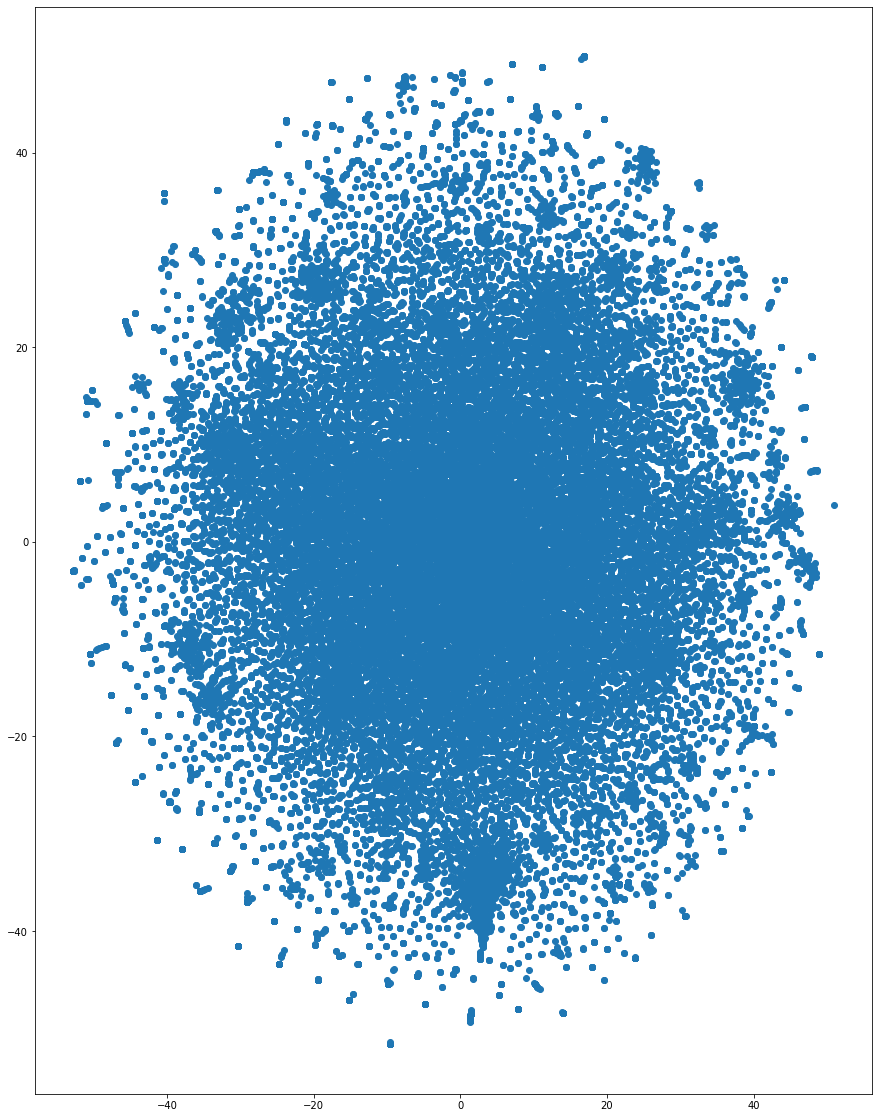

In [78]:
plt.figure(figsize=(15,20))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

## Clustering

In [31]:
from sklearn.cluster import KMeans
from collections import Counter

In [79]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(tweetvecList)

In [80]:
labels = kmeans.labels_

In [82]:
c=Counter()
for d in labels:
    c[d] += 1
print(c)

Counter({0: 39849, 2: 23, 1: 7})


In [83]:
labels2tweets=defaultdict(lambda: [])

In [84]:
for pos, label in enumerate(labels):
    labels2tweets[label].append(pos)

In [85]:
def bag_of_words_from_ids(ids):
    bag_of_words = {}
    for key in ids:
        lst_text = df_tweets['processed_text'][key]
        # create bag-of-words - for each word the frequency of the word in the corpus
        for w in lst_text:
            if w not in bag_of_words:
                bag_of_words[w] = 0
            bag_of_words[w]+=1

    return bag_of_words

In [86]:
bag_of_words0 = bag_of_words_from_ids(labels2tweets[0])
bag_of_words1 = bag_of_words_from_ids(labels2tweets[1])
bag_of_words2 = bag_of_words_from_ids(labels2tweets[2])

In [87]:
def plot_bag(bag):
    words_obj = [{'word':word, 'count': bag[word]} for word in bag]

    counter_words = pd.DataFrame(words_obj)
    counter_words.columns = ["word", "count"]
    counter_words.set_index("word", inplace=True)
    counter_words.sort_values("count", inplace=True, ascending=False)
    counter_words.head(10).plot.barh()
    plt.show()

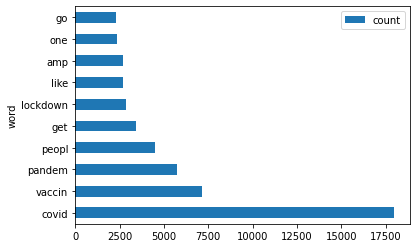

In [88]:
plot_bag(bag_of_words0)

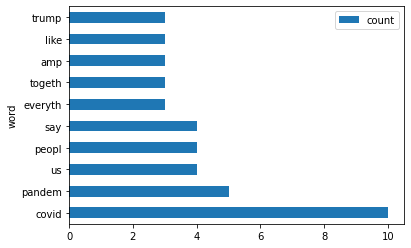

In [92]:
plot_bag(bag_of_words2)

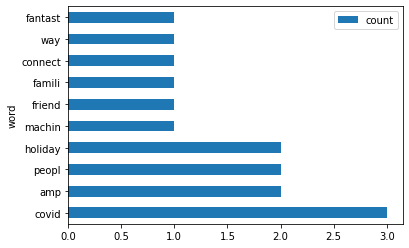

In [91]:
plot_bag(bag_of_words1)